(9, 28, 28)
W/B shape
W1/B1: (784, 64)/(64,)
W1/B1: (64, 32)/(32,)
W1/B1: (32, 10)/(10,)



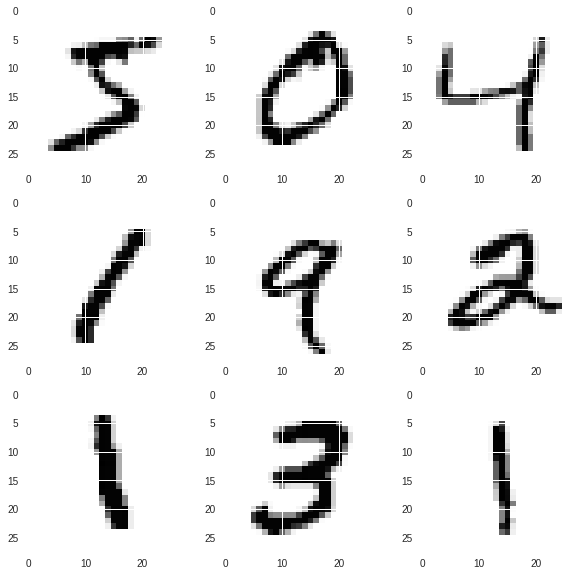

In [1]:
import numpy as np
from numpy.random import normal
from numpy import zeros

from termcolor import colored
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from tensorflow.keras.datasets.mnist import load_data

(train_images, train_labels), test_ds = load_data() # dataset을 받음
# 각각의 type은 numpy.ndarray / 각각 28 28 , 60000 shape을 갖는다. 28X28의 6만장이라고 생각하면 된다.
# 사람의 손글씨 데이터를 가지고 있다.
view_images = train_images[:9,...]
print(view_images.shape)
fig,axes = plt.subplots(3,3, figsize=(10,10))
for ax_idx, ax in enumerate(axes.flat):
  image = view_images[ax_idx]
  ax.imshow(image)


# set test env
n_data = train_images.shape[0] # train_images의 shape이 (60000,28,28) 이니까 n_data는 6만장이다.
n_feature = train_images.shape[1]*train_images.shape[2] # 28X28 개의 한 줄 Row의 feature를 만들어준다.
b_size = 64 # batch size
n_batch = n_data // b_size
epochs = 20
lr = 0.03
units = [64,32,10] # 각 dense layer마다 뉴런의 개수 
# 마지막 10개인 이유는 0~9까지 10개를 구분하기 위해서

# initialize w, b
w1 = normal(0,1,(n_feature, units[0]))
b1 = zeros((units[0]))

w2 = normal(0,1,(units[0], units[1]))
b2 = zeros((units[1]))

w3 = normal(0,1,(units[1], units[2]))
b3 = zeros((units[2]))

print(colored("W/B shape",'green'))
print(f"W1/B1: {w1.shape}/{b1.shape}") # feature의 개수가 28*28 = 784개니까 w1는 784, 뉴런개수 64 즉, (784,64)
print(f"W1/B1: {w2.shape}/{b2.shape}")
print(f"W1/B1: {w3.shape}/{b3.shape}\n")

In [2]:
losses, accs = list(),list()
for epoch in range(epochs):
  n_correct, n_data = 0,0
  for b_idx in range(n_batch):
    # get mini-batch
    images = train_images[b_idx*(b_size):(b_idx+1)*(b_size),...] # batch size만큼 인덱싱
    X = images.reshape(b_size,-1)
    # X가 batch size만큼 나눴으니까 (64,28,28) 인데, reshape(b_size,-1)을 하면 flatten이 되서 (64,784)가 된다.
    Y = train_labels[b_idx*(b_size):(b_idx+1)*(b_size),...]
    # print(X.shape, Y.shape)

    ### forward propagation
    # dense1
    Z1 = X @ w1 + b1
    A1 = 1/(1+np.exp(-Z1))
    # dense2
    Z2 = A1 @ w2 + b2
    A2 = 1/(1+np.exp(-Z2))
    # dense3 ( no activation or linear)
    L = A2 @ w3 + b3
    # softmax
    Pred = np.exp(L)/np.sum(np.exp(L),axis=1, keepdims=True) # keepdims -> 차원 유지
    # softmax가 colum은 각각의 데이터 그리고 각 row마다 합이 1이고, 그중 1개의 L의 비율이므로 sum 을 axis = 1 즉, row로 더해준다.

    # loss
    J = np.mean(-np.log(Pred[np.arange(b_size),Y])) # CCEE # np.arange 는 배열을 만드는 함수
    # Pred[np.arange(b_size),Y] 는 np.arange(b_size)는 b_size 만큼 row에 대한 index가 되고, Y 는 1이 들어있는 값만 뽑아오는 것이 된다.
    # 즉 label만 뽑아오는게 된다.
    losses.append(J)

    # calculate accuracy
    Pred_label = np.argmax(Pred, axis=1) # row 값 중에 가장 큰값으로 된 부분이 모델이 예측한 것이기 때문에, argmax를 통해 최대값을 찾는다.
    n_correct += np.sum(Pred_label == Y)
    n_data += b_size

    ### backporpagation
    labels = Y.copy() # 그냥 labels = Y 하면 주소가 복사 되서 Y가 바뀌니까 .copy() 사용
    Y = np.zeros_like(Pred)
    Y[np.arange(b_size),labels] = 1 # one-hot encoding을 해준것
    #loss
    dL = -1/b_size*(Y-Pred) # batch로 만들었기 때문에 N 이 아니라 b_size사용
    # dense 3 (no activation)
    dA2  = dL @ w3.T
    dw3 =  A2.T @ dL
    db3 = np.sum(dL,axis=0)
    # dense 2
    dZ2 = dA2 * A2*(1-A2) # sigmoid
    dA1 = dZ2 @ w2.T
    dw2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis = 0)
    # dense 1 
    dZ1 = dA1 * A1*(1-A1)
    dw1 = X.T@ dZ1 
    db1 = np.sum(dZ1, axis = 0)

    # parmeter update
    w3, b3 = w3 - lr*dw3, b3 - lr*db3
    w2, b2 = w2 - lr*dw2, b2 - lr*db2
    w1, b1 = w1 - lr*dw1, b1 - lr*db1
  accs.append(n_correct/n_data) # 정답 확률

"""  GPU의 속도를 빠르게 하기 위해서 for문을 사용하는거 대신에, 식을 이용해서 한번에 표현한다 """

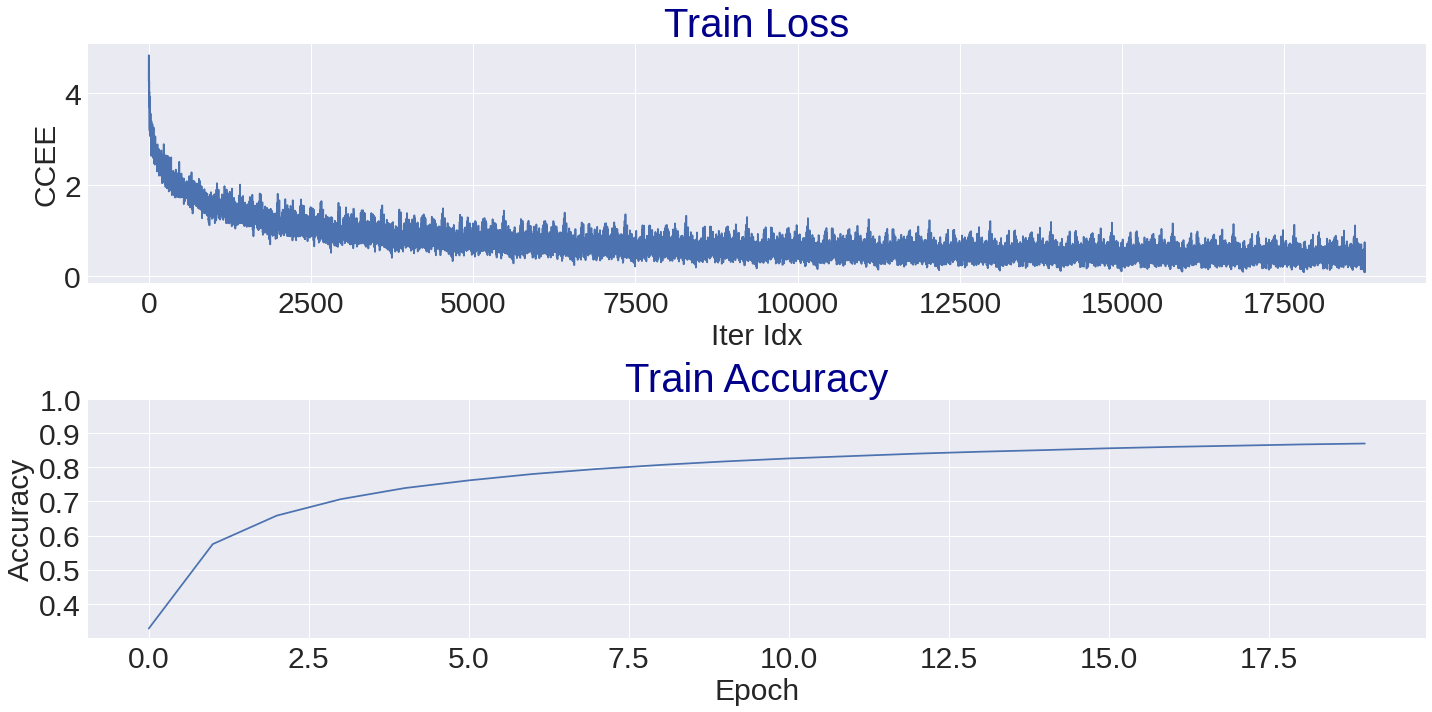

In [3]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
axes[0].plot(losses)
axes[1].plot(accs)
axes[0].set_title("Train Loss",color ='darkblue', fontsize=40)
axes[0].set_xlabel("Iter Idx",fontsize=30)
axes[0].set_ylabel("CCEE",fontsize=30)

axes[1].set_title("Train Accuracy",color ='darkblue', fontsize=40)
axes[1].set_xlabel("Epoch",fontsize=30)
axes[1].set_ylabel("Accuracy",fontsize=30)
axes[1].set_yticks(np.linspace(0.4,1.0,7))

axes[0].tick_params(labelsize = 30)
axes[1].tick_params(labelsize = 30)
fig.tight_layout()

""" 결과를 보면 Loss는 줄어들고, 정확성이 0.9 즉, 90프로까지 상승하는 것을 볼 수 있다."""